In [1]:
cd ..

/Users/huttercl/Documents/StrokeRecovery/CorrelationGraph4Stroke_public


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from StrokeRecovery import utils
import seaborn as sb
import matplotlib.pyplot as plt

version = 'v1.6'
removals = list()
name_of_reason_col = 'ReasonForRemoval'

In [3]:
patients = pd.read_excel('data/ds1a_patients_{}.xlsx'.format(version)).set_index('uID_eth', verify_integrity=True)

In [4]:
patients1 = patients

## Entry after stroke
Remove patients that enter rehab more than 21 days after the stroke

In [5]:
day_threshold = 21
patients1['entry_N_days_after_stroke'] = patients1['EintrittDatum_SN'] - patients1['DatumErkrankung_SN'] 

remove_late_entry = patients1[patients1['entry_N_days_after_stroke'] > dt.timedelta(days=day_threshold)].copy()
remove_late_entry[name_of_reason_col] = 'entry more than {} days after stroke'.format(day_threshold)

removals.append(remove_late_entry)

patients2 = patients1.drop(index= remove_late_entry.index)
patients1 = None
print('{} patients removed because they entered more than {} days after stroke'.format(len(remove_late_entry), day_threshold))


69 patients removed because they entered more than 21 days after stroke


## LIMOS

In [6]:
patients5 = patients2.sort_index()

In [7]:
limos_all = pd.read_excel("data/ds1b_limos_{}.xlsx".format(version), index_col=[0,1])

In [8]:
limos_selected = limos_all.loc[patients5.index]

In [9]:
contains_missing = (pd.isnull(limos_selected).sum(axis=1)>0)

In [10]:
limos_measurements_with_missing_values = limos_selected[contains_missing]

In [11]:
print("{} weekly limos measurements have at least one category without any value and are removed".format(len(limos_measurements_with_missing_values)))

35 weekly limos measurements have at least one category without any value and are removed


In [12]:
limos2 = limos_selected[~contains_missing]
limos_selected = None

In [13]:
if 'a_ESN' in limos_measurements_with_missing_values.index.get_level_values(1):
    ids_with_missing_entry = limos_measurements_with_missing_values.xs('a_ESN', level=1).index.values

    patients_with_missing_entry = patients5.loc[ids_with_missing_entry].copy()

    print("{} patients had a missing value in entry and are removed".format(len(patients_with_missing_entry)))
    patients_with_missing_entry[name_of_reason_col] = 'removed because missing LIMOS in the first (entry) measurement'
    removals.append(patients_with_missing_entry)
    patients6a = patients5.drop(index=patients_with_missing_entry.index)
    limos3a = limos2.drop(index=patients_with_missing_entry.index)

else:
    print("no patients had missing entry values")
    patients6a = patients5
    limos3a = limos2


patients5 = None
limos2=None
patients_with_missing_entry = None


no patients had missing entry values


In [14]:
if 'g_ASN' in limos_measurements_with_missing_values.index.get_level_values(1):
    ids_with_missing_exit = limos_measurements_with_missing_values.xs('g_ASN', level=1).index.values
    patients_with_missing_exit = patients6a.loc[ids_with_missing_exit].copy()
    
    print("{} patients had a missing value in exit and are removed".format(len(patients_with_missing_exit)))
    
    patients_with_missing_exit[name_of_reason_col] = 'removed because missint LIMOS in the last (exit) measurement'
    removals.append(patients_with_missing_exit)
    
    patients6b = patients6a.drop(index=patients_with_missing_exit.index)
    limos3b = limos3a.drop(index=patients_with_missing_exit.index)
    
else:
    print("no patients had missing exit values")
    patients6b = patients6a
    limos3b = limos3a

patients6a = None
limos3a = None

no patients had missing exit values


In [15]:
limos3 = limos3b
patients6 = patients6b

limos3b = None
patients6b = None

## Fill in extra info for patients

In [16]:
n_measurements = limos3.reset_index().groupby('uID_eth').count()['time']

patients6['n_measurements'] = n_measurements

In [17]:
duration_of_stay = patients6['AustrittDatum_SN'] - patients6['EintrittDatum_SN']


In [18]:
assert np.all(duration_of_stay.dt.components.loc[:, 'hours':] == 0) # only days should be defined

patients6['duration_of_stay'] = duration_of_stay.dt.days
patients6['avg_delta_between_measurements'] = patients6['duration_of_stay'].astype(float) / (patients6['n_measurements'].astype(float)-1)

In [19]:
patients6['age'] = (patients6['EintrittDatum_SN'] - patients6['Geburtstagsdatum_SN']) / np.timedelta64(1, "Y")

# Time in between measurements

(0.0, 20.0)

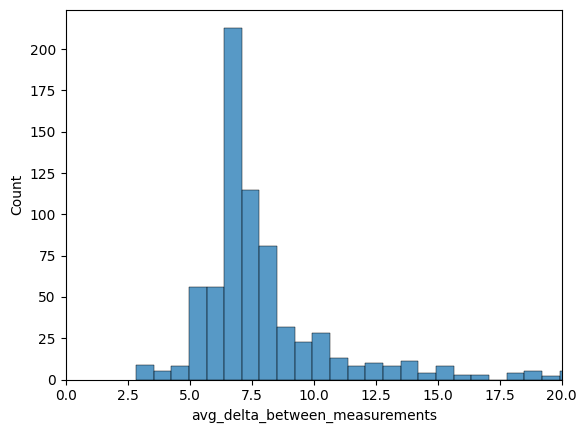

In [20]:
sb.histplot(patients6, x='avg_delta_between_measurements', bins=100)
plt.xlim([0,20])

In [21]:
def filter_patients(patients, min_delta, max_delta):
    selector =  (min_delta <= patients['avg_delta_between_measurements']) & (patients['avg_delta_between_measurements'] <= max_delta)
    
    fraction = np.mean(selector)
    print("Taking {ntake} out of {ntotal}, i.e. {fraction:.1f}% of all patients, which have measurements between every {daymin} and {daymax} days".format(
        ntake=np.sum(selector), ntotal=len(selector),  fraction=fraction*100, daymin=min_delta, daymax=max_delta))
    
    selected_patients =  patients[selector]
    n_measurements = selected_patients['n_measurements'].value_counts()
    print("The following are the number of measurements we have for these patients:")
    print(n_measurements)
    return selected_patients

In [22]:
patients7 = filter_patients(patients6, 5, 10) # take only patients where the time between measurements is between 5 and 10 days
removed_because_of_spacing = patients6.drop(index=patients7.index.values)

patients6 = None

limos4 = limos3.loc[patients7.index]
limos3 = None


Taking 592 out of 776, i.e. 76.3% of all patients, which have measurements between every 5 and 10 days
The following are the number of measurements we have for these patients:
7    164
4    135
5    106
3     85
6     84
2     18
Name: n_measurements, dtype: int64


In [23]:
removed_because_of_spacing[name_of_reason_col] = 'spacing between measurements wrong'
removals.append(removed_because_of_spacing)

# Finalizing

In [24]:
final_limos = limos4
final_patients = patients7

In [25]:
assert pd.isnull(final_limos).values.sum() == 0 # i.e. no missing limos

lim_index = final_limos.index.get_level_values('uID_eth').unique().values
pat_index = final_patients.index.values

assert len(lim_index) == len(pat_index)
assert np.all( lim_index == pat_index )

In [26]:
columns_to_use = [
       'entry_N_days_after_stroke', 'age', 'Geschlecht_SN',
       'loc_label', 'diag_label', 'n_measurements', 'duration_of_stay',
       'avg_delta_between_measurements', 'NIHHSnachLyseThrombek_SN']

In [27]:
final_patients[columns_to_use].sort_index().to_excel('data/ds2a_patients_{}.xlsx'.format(version))
final_limos.to_excel('data/ds2b_limos_{}.xlsx'.format(version))

In [28]:
removalsDF = pd.concat(removals).sort_index()
removalsDF.to_excel('data/ds1_removed_patients_{}.xlsx'.format(version))